### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2016 ###

# Travel Planning #

#### Shengchao Liu (CS login: shengchao, email: shengchao@cs.wisc.edu)
#### Honghui Zhang (CS login: honghui, email: hzhang459@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
  1. [Basic Model](#2.A.-Basic-Model)
  2. [Visiting Bounded Model](#2.B.-Bounded-Model)
  3. [Adaptive Method](#2.C.-Adaptive-Method)
1. [Solution](#3.-Solution)
  1. [Interactive Block](#3.A.-Interactive-Block)
  2. [Data Source](#3.B.-Data-Source)
  3. [Helper Function](#3.C.-Helper-Function)
  4. [Bounded Model](#3.D.-Bounded-Model)
1. [Results and Discussion](#4.-Results-and-discussion)
  1. [Performance Test](#4.A.-Performance-Test)
  2. [Limitations](#4.B.-Limitations)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

Suppose you have one or two available weeks, and you want to visit some cities in the U.S., especially for international students who just came to U.S., you may have a city list that you would like to visit, also another city list you don't want to pay a visit to. So how you can come up with a travel plan?

This question is very similar to TSP ([Travelling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)). The Travelling Salesman problem is like this, suppose we have a bunch of cities and we would like visit all of them in a round trip. Target is to get the minimal length or cost of this round trip.

Another similar question is the [Steiner Tree Problem](https://en.wikipedia.org/wiki/Steiner_tree_problem).  Steiner Tree problem forms a tree out of a complex graph, but under the condition that minimizing the spanning tree cost only cover the must-pass nodes. So if we apply that model into our problem, it's like get a special Steiner 'tree' that starts from the root and ends at root with just one path.

In our problem, given all the possible cities that we can choose to visit, and another must-visit city list and must-not-visit city list. Then under time and expense constraints, we hope to find a route that maximizes the delight index. The delight index is based on the some travel index for each city plus delight index for each air flight. We may need to find a trade-off between these parameters. For example, in the graph below, we have twelve cities, and we need to choose which city to start and end with, then also specify all the must-visit cities and must-not-visit cities.


![alt text](http://pages.cs.wisc.edu/~shengchao/cs524/all_city_map.png)

To make our model more realistic, we fetch real data online. First we take [walk score](https://www.walkscore.com/cities-and-neighborhoods/) to measure each city, which makes sense considering most students like walking while travelling. As for flight and aiport information, we utilize the [Expedia API](http://hackathon.expedia.com/directory) and [Google Maps Geocoding API](https://developers.google.com/maps/documentation/geocoding/intro), and then calculate the delight index with a fixed function for each flight.

In part 2, we will first extract a basic model out of the problem, then apply more reasonable constraints to it. In part 3, we will give a specific code solution. Part 4 discuss the results, and part 5 just summarizes the whole problem.


## 2. Mathematical model ##


### 2.A. Basic Model ###

We define the following assumption for our basic model.

Assumption 1: we assume that flying from one city to another city takes exactly one day, and visiting one city takes exactly two days.

Assumption 2: Price didn't change within adjacent several days.

Assumption 3: Each city visit just once.

First notice we will introduce the incidence matrix $ matrix \in \cal{R}^{v \times e} $ in our model, where $v$ is the number of vertices or cities, and  $e$ is the number of edges, that is two times city number plus flight number(will explain why two time city number later), and $b$ is the supposed  The vector $edge \in \cal{R}^{e}$ is the edge choice. So apparently we can get these two contraints:

$$ matrix \times edge == b$$, where b is the supposed in- or out- degree for each vertice or city.

$$ abs(matrix) \times edge . \le 2$$, which means the sum of in- and out- degree for each city should be less than or equal to two.

Second we need to meet the time and cost limit. Suppose $city\_choice \in \cal{R}^{v}$ is binary value vector, and $city\_choice[i] = 1$ represents $city[i]$ will be visited, otherwise if $city\_choice[i] = 0$ will not visit $city[i]$. Same idea for $flight\_choice$ which represents whether or not taking $flight[i]$. So according to problem, we can get these two limits:

$$ flight\_choice^T \times flight\_price \le total\_money $$

$$ 2sum( city\_choice) +  sum(flight\_choice) \le total\_day $$

We still have one question not solved, that is why we need $2 \times city\_number$. Please consider the graph below, we split each city node into two. The reason we do that is that, suppose $edge$ is composed only by the $flight$, and we meet the constraints. But still, we don't know which city will form a single circle, like the $city_A$ in this graph, which means in the adaptive method, we will detect only one circle( that is $city_B$ - $city_C$ - $city_D$) in the graph, which is absolutely wrong. That's why we want to split each city node into two, because it can help us find all possible circles or subtours in the graph, then applying adaptive method will be reasonable.


<img src="http://pages.cs.wisc.edu/~shengchao/cs524/picture1.png" height="542" width="542">

To sum up, below is a standard form:

$$
\begin{aligned}
\underset{city\_choose,\, flight\_choose}{\text{maximize}}\qquad& city\_score^T \times city\_choose + flight\_score^T \times flight\_choose \\
\text{subject to:}\qquad& 
  matrix \times edge == b \\
& abs(matrix) \times edge . \le 2 \\
& flight\_choice^T \times flight\_price \le total\_money \\
& 2sum( city\_choice) +  sum(flight\_choice) \le total\_day \\
\end{aligned}
$$


### 2.B. Bounded Model ###

Then we may come up with another idea: in a more realistic scenario, people will have an upper bound travelling day for each city, instead of exactly 2 days, which makes sense because someone just hope to visit several different cities within 2 week-holiday.

Assumption: visiting day for each city will be bounded by a upper bound and a lower bound. And the delight index for visiting one city is calculated by the city score multiply by its corresponding visiting day.

We introduct a new vector $day\_each\_city \in \cal{R}^{v}$, denoting the travelling day for each city, and its upper bound is $city\_day\_upperlimit$. So apparently we can get following relations:

If $city\_choice[i] = 1$, then $ city\_day\_lowerlimit[i] \le day\_each\_city[i] \le city\_day\_upperlimit[i]$, for $ i=1,\dots,v $.

If $city\_choice[i] = 0$, then $day\_each\_city[i] == 0$, for $ i=1,\dots,v $.

Then applying the if-then constraint:

$$ day\_each\_city[i] - city\_day\_lowerlimit[i] \ge m (1 - city\_choice[i]) = city\_day\_lowerlimit[i] \times city\_choice[i]$$

$$ day\_each\_city[i] \le M day\_each\_city[i] = city\_day\_upperlimit[i] \times city\_choice[i] $$

for $ i=1,\dots,v $.

And also we notice that the upper bound for visiting each city $city\_day\_lowerlimit[i] \le day\_each\_city \le city\_day\_upperlimit$ is included in the if-then constraints, so we don't have to explicitly demonstrate it.

Therefore the standard form for this is below:


$$
\begin{aligned}
\underset{city\_choose,\, flight\_choose}{\text{maximize}}\qquad& city\_score^T \times city\_choose + flight\_score^T \times flight\_choose \\
\text{subject to:}\qquad& 
  matrix \times edge == b \\
& abs(matrix) \times edge . \le 2 \\
& flight\_choice^T \times flight\_price \le total\_money \\
& sum( day\_each\_city) +  sum(flight\_choice) \le total\_day \\
& - day\_each\_city[i] \le -city\_day\_lowerlimit[i] \times city\_choose[i] && i=1,\dots,v\\
& day\_each\_city[i] \le city\_day\_upperlimit[i] \times city\_choose[i] && i=1,\dots,v
\end{aligned}
$$

### 2.C. Adaptive Method ###

We apply the adaptive subtour elimination. Find subtours and the get the number of subtours. If the subtour number is bigger than one, then we add a constraint that this circle should not be reached, so that we can avoid having multiple circles in the graph.

One key tip is that, in our model, since we start our trip from Madison, the out-degree of Madison will be 1, and in-degree of Madison will be -1, in which case this will not form a circle itself. So we have to manually search the subtour starting from the Madison at first in each iteration, so that we can find the very first route starting from Madison and back to Madison.

<img src="http://pages.cs.wisc.edu/~shengchao/cs524/picture2.png" height="542" width="542">


## 3. Solution ##

### 3.A. Interactive Block###

In the first part, we will present interactive block.

By default, we have these 12 cities in the interactive section:

<table>
    <tr>
        <th>City Name</th>
        <th>Number</th>
    </tr>
    
    <tr>
        <td>New York</td>
        <td>1</td>
    </tr>
    
    <tr>
        <td>Boston</td>
        <td>2</td>
    </tr>
    
    <tr>
        <td>Washington D.C.</td>
        <td>3</td>
    </tr>
    
    <tr>
        <td>Chicago</td>
        <td>4</td>
    </tr>
    
    <tr>
        <td>Minneapolis</td>
        <td>5</td>
    </tr>
    
    <tr>
        <td>Atlanta</td>
        <td>6</td>
    </tr>
    
    <tr>
        <td>Miami</td>
        <td>7</td>
    </tr>
    
    
    <tr>
        <td>Orlando</td>
        <td>8</td>
    </tr>
    
    
    <tr>
        <td>Los Angeles</td>
        <td>9</td>
    </tr>
    
    <tr>
        <td>San Francisco</td>
        <td>10</td>
    </tr>
    
    
    <tr>
        <td>Seattle</td>
        <td>11</td>
    </tr>
    
    <tr>
        <td>Madison</td>
        <td>12</td>
    </tr>
</table>

And in this interactive block, you are able to set the following perferences.

- you can type in which city you want to visit and which city you don't want to visit. We define the vector $city\_requirement$ in this way:

$$ city\_requirement[i] = \begin{cases}
 1, & {\text{must visit city[i]}}\\
 0, & {\text{must not visit city[i]}}\\
-1, & {\text{possibly visit city[i]}}\\
\end{cases}
$$
- you can define a city's delight score if you want (a number between 0 and 100. The higher the number is, the more delight you think you will get when you travel in this city). If you don't want to give a city a delight score, please just set it to -1.
$$ city\_pre\_score[i] = \begin{cases}
 your\ preference, & {\text{a number between 0 and 100}}\\
-1, & {\text{use our walk score for the city[[i]}}\\
\end{cases}
$$
- you can set the upper limit and lower limit of days that you want to stay/play in each cities. The dafult setting is 3 days.
- you can declare which is the starting/ending city as the #seed\_city# here (which is also the ending city) and how many days you want to stay/play in this seed city.
- you can declare the the limit of the money and days you want to spend in this trip

In [1]:
# requirement : 1 = must visit; 0 = must not visit; -1 = possibly visit
city_requirement    = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]

# upper limit and lowerlimit of days if stay in a city : nonnegative integer
city_day_upperlimit = [3  3  3  3  3  3  3  3  3  3  3  3]
city_day_lowerlimit = [1  1  1  1  1  1  1  1  1  1  1  1]

# city score : 0~100. And -1 = default (walk scores)
city_pre_score      = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]

# the starting/ending city
seed_city = 12
seed_city_day_upperlimit = 0
city_day_upperlimit[seed_city] = seed_city_day_upperlimit

# max amout of money spend on flight (dollars)
max_money = 10000

# max travel days
max_day = 10;

### 3.B. Data Source###

To make our model more realistic, we fetch real data online. First we take [walk score](https://www.walkscore.com/cities-and-neighborhoods/) to measure each city, which makes sense considering most students like walking while travelling. As for flight and aiport information, we write the Python program ([expedia.py](https://github.com/lscHacker/Steiner-Tree-in-Flight-Scheduling/blob/master/expedia.py)) to utilize the [Expedia API](http://hackathon.expedia.com/directory) to capture real-time flight information, and [Google Maps Geocoding API](https://developers.google.com/maps/documentation/geocoding/intro) to capture the latitude and longitude of the cities. 

Then we use the following function to simulate the delight index for each flight.

$$ flight\ comfort = 50 * \frac{1}{\#\ of\ segments} + 50 * \max(0, 1 - e^{-4+0.5*(flight\ hours)})$$

The idea of the function is that:
- With the increase of the number of segments, the delight index will decrease rapidly at the begining, and then decrease slowly. We believe that most people perfer non-stop flight, and more the segements the flight have, more tiring the trip is.
- With the increase of the flight hours, the delight index will decrease slowly at the begining, and then decrease rapidly. We believe that the longer the trip takes, more tiring and boring the trip is. If the flight hour is more than 8 hours, the delight index will remain the same and pretty low.

We then write a Matlab program([delight_curve.m](https://github.com/lscHacker/Steiner-Tree-in-Flight-Scheduling/blob/master/delight_curve.m)) to demonstrate more straightforward. The following is the delight index curve.

<img src="http://pages.cs.wisc.edu/~shengchao/cs524/delight_curve.jpg" height="542" width="542">



Finally, we can generate the following csv file.

- [flight.csv](https://github.com/lscHacker/Steiner-Tree-in-Flight-Scheduling/blob/master/flights.csv), which records all the flight information that we need.
- [location.csv](https://github.com/lscHacker/Steiner-Tree-in-Flight-Scheduling/blob/master/location.csv), which records all the city information that we need.


In [2]:
function loadCSV()
    # Load the city information
    global city, city_lat, city_lon, city_number, city_pre_score, score, city_score
    locations = readdlm("locations.csv", ',')
    city  = locations[2:end, 1]
    lat   = locations[2:end, 3]
    lon   = locations[2:end, 4]
    score = locations[2:end, 5]

    city_lat   = Dict(zip(city, lat))
    city_lon   = Dict(zip(city, lon))
    city_number = size(city, 1)
    for i = 1:city_number
        if (city_pre_score[i] != -1)
            score[i] = city_pre_score[i]
        end
    end
    city_score = Dict(zip(city, score))

    # Load the flight information
    global departure_city, departure_airport, arrival_city, arrival_airport
    global flight_date, flight_price, flight_comfort, flight_number
    flights  = readdlm("flights.csv", ',')
    departure_city    = flights[2:end, 1]
    departure_airport = flights[2:end, 2]
    arrival_city      = flights[2:end, 3]
    arrival_airport   = flights[2:end, 4]
    flight_date       = flights[2:end, 5]
    flight_price      = flights[2:end, 6]
    flight_comfort    = flights[2:end, 7]
    flight_number     = size(flights, 1) - 1
end;

Then we form the $matrix$. As we discussed above, the first $2 city\_number$ whould describe the city itself, in case we don't want to visit somewhere else. For $city[i]$, we split it into two subnodes, $2i-1$ and $2i$. $2i-1$ is the in-degree node, and $2i$ is the out-degree node. Then add two edges: from $2i-1$ to $2i$ and from $2i$ back to $2i-1$. In this case, we will not miss the single-city circle.

And applying our splitting nodes concept for the flight from $city[u]$ to $city[v]$, we should add an edge from $2u$ to $2v-1$.

In our default setting, we are leaving from Madison, and back to Madison, which means the tour should start from $2 Madison_{index}$ and back to $2 Madison_{index} - 1$, so the b vector should have all zero except $b[2 Madison_{index}]=1$ and $b[2 Madison_{index}-1]=-1$.

In [3]:
function formMatrix()
    global matrix, city_number, flight_number, b
    global departure_city, arrival_city, city
    
    matrix = zeros(2city_number,2city_number + flight_number);
    # split each city into two 'subcities'
    for i = 1 : city_number
        matrix[2i-1, 2i-1] = 1
        matrix[2i  , 2i-1] = -1
        matrix[2i-1, 2i] = -1
        matrix[2i  , 2i] = 1
    end
    for i = 1 : flight_number
        u = 1
        v = 1
        for j = 1 : city_number
            if departure_city[i] == city[j]
                u = j
            end
            if arrival_city[i] == city[j]
                v = j
            end
        end
        matrix[2u  ,i+2city_number] = 1
        matrix[2v-1,i+2city_number] = -1
    end
    b = zero(1:2city_number)
    b[2seed_city-1] = -1
    b[2seed_city] = 1
end;

### 3.C. Helper Function###

The followings are the helper functions.

The function getAllSubtours() gets all the subtours given the edges that we choose in each iteration. It calls function getSubtour(), which starts from one edge and find a circle back to this edge.

And in previous section, we discussed one important idea that manually search the subtour starting from the Madison at first. So put this getInitialEdge() before calling getSubtour(), and find the subtour either starting from Madison or the first edge in the remaining edges.

In [4]:
function getInitialEdge(remaining)
    len = size(remaining)[1];
    for i in 1:len
        edge_no = remaining[i]
        # MODIFIED
        if matrix[2*seed_city, edge_no] == 1
            return i
        end
    end
    return 1
end

function get_city_from_edge(no)
    arr = matrix[:,no]
    u = 0
    v = 0
    for i = 1 : 2city_number
        if arr[i] == 1
            u = round(Int,ceil(i/2));
        end
        if arr[i] == -1
            v = round(Int,ceil(i/2));
        end
    end
    return u, v
end

# print all the edges, including flight and circle for one city itself
function print_out_edge(edge)
    for i = 1 : 2city_number + flight_number
        if edge[i] > 0
            if i<= 2city_number && i%2 == 1
                continue
            end
            u , v = get_city_from_edge(i)
            println(i, " ", city[u], "  to  ", city[v])
        end
    end
end

# print all the flights
function print_out_flight(flight)
    for i = 1 : flight_number
        if flight[i] > 0
            println(i,' ',departure_city[i], "  to   ", arrival_city[i]);
        end
    end
end

# HELPER FUNCTION: returns the cycle containing the city START.
function getSubtour(edge_remaining, start_edge)
    subtour = [start_edge];
    start_u, start_v = get_city_from_edge(edge_remaining[start_edge]);

    pre_u = start_u;
    pre_v = start_v;
    while true
        for i = 1 : size(edge_remaining)[1]
            if i in subtour
                continue
            end
            temp_u, temp_v = get_city_from_edge(edge_remaining[i]);
            if temp_u == pre_v
                push!(subtour, i);
                pre_u = temp_u;
                pre_v = temp_v;
                break
            end
        end
        if pre_v == start_u
            break
        end
    end
    return subtour;
end

# HELPER FUNCTION: returns a list of all cycles
function getAllSubtours(edge_chosen_list)
    edge_remaining = edge_chosen_list
    subtours = []
    while length(edge_remaining) > 0
        initial_edge_in_remaining_list = getInitialEdge(edge_remaining)
        subtour = getSubtour(edge_remaining, initial_edge_in_remaining_list)
        # the subtour contains only the number in remaining list
        # Ex. if remaining list = [ 10 12 4 7], and [10 4] is a cycle, then subtour here is [1 3]
        push!(subtours, edge_remaining[subtour])
        edge_remaining = setdiff(edge_remaining, edge_remaining[subtour])
    end
    return subtours
end

using PyPlot
using PyCall
@pyimport mpl_toolkits.basemap as basemap

# Helper function: plot a solution
function mapSolution(x=0)
    m=basemap.Basemap(projection="merc", resolution="l",llcrnrlat=22,llcrnrlon=-130,urcrnrlat=52,urcrnrlon=-60)
    lightBlue = (220/255, 220/255, 255/255)
    lightGreen = (230/255, 255/255, 230/255)
    m[:drawcoastlines](linewidth=0.5)
    m[:drawcountries](linewidth=0.25)
    m[:drawmapboundary](fill_color=lightBlue)
    m[:fillcontinents](color=lightGreen, lake_color=lightBlue)
    
    # m[:drawmeridians](collect(-180:20:180), labels=[1,1,0,1])
    # m[:drawparallels](collect(10:10:90), labels=[1,1,0,1])

    # plot airports
    for i in city
        m[:plot](city_lon[i], city_lat[i], "ro" ,latlon=true)
    end

    # plot tours
    if x==0
        return
    else
        for i = 1 : 2city_number + flight_number
            if x[i] > 0
                if i<= 2city_number && i%2 == 1
                    continue
                end
                u , v = get_city_from_edge(i)
                if (u == v)
                    m[:plot](city_lon[city[u]], city_lat[city[u]], "bo" ,latlon=true)
                else
                    m[:drawgreatcircle](city_lon[city[u]],city_lat[city[u]],city_lon[city[v]],city_lat[city[v]],linewidth=1,color="b")
                end
            end
        end
    end
end

# Helper function: plot the iterations as we eliminate subtours
function plotIterations(sols)
    num_sol = size(sols,1)
    num_plt = min(9, num_sol)
    figure(figsize=(20,12))
    for i = 1:num_plt
        subplot(3,3,i)
        mapSolution(sols[num_sol - num_plt + i])
        xlabel(string("iteration ",num_sol - num_plt + i))
    end
end;

### 3.D. Bounded Model ###

Here just put all our models discussed before, and combined them together. The parameter "printed" means whether print the iterations and the solution out. If "printed == 0", we will not print them out. Otherwise, we will print them out.

In [5]:
using JuMP

function runModel(printed = 0)
    global seed_city, max_day, max_money, city_day_upperlimit, city_day_lowerlimit
    global city_number, flight_number, flight_price, score
    global matrix, b
    
    m = Model()
    # city that will spend some days to travel
    @variable(m, city_choice[1:city_number], Bin)
    # flight that will be chosen
    @variable(m, flight_choice[1:flight_number], Bin)
    # edge consists of 11 pairs of split sub-cities, and 320 flights
    @variable(m, edge[1:2city_number + flight_number], Bin)
    # time spent on each city
    @variable(m, day_each_city[1:city_number] >= 0, Int)

    # first 22 of edges should match the city_choice
    # MODIFIED
    @constraint(m, constr[i in 1:seed_city - 1], edge[2i-1] == city_choice[i])
    @constraint(m, constr[i in seed_city+1:city_number], edge[2i-1] == city_choice[i])
    #@addConstraint(m, c1[i=1:city_number - 1], edge[2i-1] == city_choice[i])
    # the remaining edges should match the flight
    @constraint(m, c2[i=1:flight_number], edge[i+2city_number] == flight_choice[i])

    # should be a round trip
    @constraint(m, matrix * edge .== b)
    # each point should have at most one out degree and one in degree
    @constraint(m, abs(matrix) * edge .<= 2)

    # set must-visit and must-not-visit city
    for i in 1:city_number
        if city_requirement[i] == 1
            @constraint(m, city_choice[i] == 1)
        elseif city_requirement[i] == 0
            @constraint(m, city_choice[i] == 0)    
        end
    end

    # restriced by money limit
    @constraint(m, sum{flight_choice[i] * flight_price[i], i=1:flight_number} <= max_money)
    # restricted by travel day limit
    # assumption: spend two days at each city, and one day on each flight
    @constraint(m,  sum(day_each_city) + sum(flight_choice) <= max_day)

    # day spent on each city should be less than its upper limit
    # MODIFIED
    @constraint(m, constr[i in 1:city_number], day_each_city[i] <= city_day_upperlimit[i] * city_choice[i])
    @constraint(m, constr[i in 1:city_number], day_each_city[i] >= city_day_lowerlimit[i] * city_choice[i])

    # try to max the comfortable indexes
    @objective(m, Max, sum{score[i]*day_each_city[i], i=1:city_number} + sum{flight_comfort[i] * flight_choice[i], i=1:flight_number})

    # record the solutions in different iterations
    global sols
    sols = []

    for iter = 1 : 1000
        solve(m)
        if (printed != 0)
            println("current comfort is :  ", getobjectivevalue(m))
            println(getvalue(day_each_city))
        end
        edge_choice_exist = getvalue(edge)
        edge_chosen_list = []
        for i = 1 : flight_number+2city_number
            if edge_choice_exist[i] > 0
                push!(edge_chosen_list, i)
            end
        end
        subtours = getAllSubtours(edge_chosen_list)
        # subtours is a big map
        for subtour in subtours
            L = length(subtour);
            @constraint(m, sum{edge[subtour[i]], i = 1:L} <= L-1)
        end
        if (printed != 0)
            print_out_edge(getvalue(edge))
            println("\n")
        end
        push!(sols,getvalue(edge))
        len = length(subtours)
        if len == 1
            println("solved")
            println("maximum comfort is :  ", getobjectivevalue(m))
            println(getvalue(day_each_city))
            print_out_edge(getvalue(edge))
            println("\n")
            break
        end
    end
end;

Based on the work above, we then can define the following funtion - "solveProblem".

In [6]:
function solveProblem(printed = 0)
    loadCSV()
    formMatrix()
    runModel(printed)
    plotIterations(sols)
end;

current comfort is :  898.3477687586051
[3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0]
24 Madison  to  Madison
25 New York  to  Boston
58 Boston  to  New York
349 San Francisco  to  Seattle
382 Seattle  to  San Francisco


current comfort is :  895.7621585583831
[2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
25 New York  to  Boston
61 Boston  to  Washington D.C.
91 Washington D.C.  to  New York
187 Minneapolis  to  Madison
400 Madison  to  Minneapolis


current comfort is :  895.7258001726398
[2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
25 New York  to  Boston
61 Boston  to  Washington D.C.
93 Washington D.C.  to  New York
188 Minneapolis  to  Madison
400 Madison  to  Minneapolis


current comfort is :  895.6969342460696
[2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
27 New York  to  Boston
61 Boston  to  Washington D.C.
93 Washington D.C.  to  New York
187 Minneapolis  to  Madison
401 Madison  to  Minneapolis


current comfort is :  895.6749025031013
[2.0,1.0,1.0,0.0,1.0

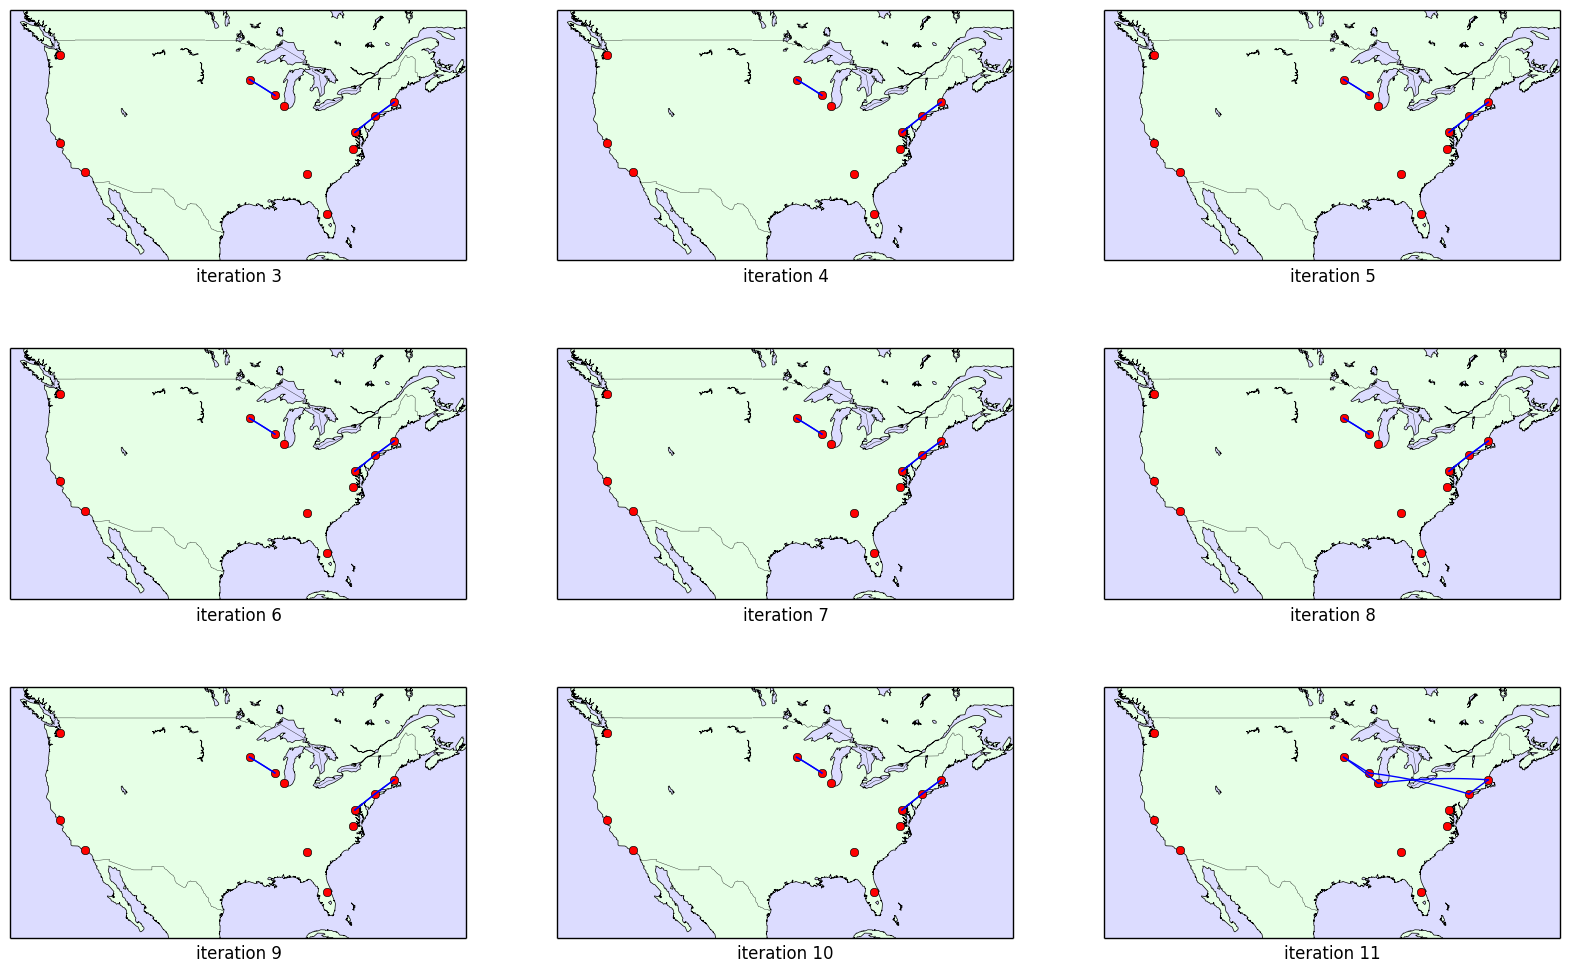

In [7]:
solveProblem(1)

## 4. Results and discussion ##



In this part, we are going to test the performance of our model.

### 4.A. Performance Test###

### Test 1

In this test, our seed_city is Madison and other setting are all default. We run our functions, and then get the following results.

- Our travel plan is
    - Madison => Minneapolis (stay 1 day)
    - Minneapolis => Chicago (stay 1 day)
    - Chicago => Boston (stay 1 day)
    - Boston => New York (stay 2 days)
    - New York => Madison (travel end)
    
   
- The flights will take 4 days


- This travel plan seems reasonable

In [8]:
# Test setting [1]
city_requirement    = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
city_day_upperlimit = [3  3  3  3  3  3  3  3  3  3  3  3]
city_day_lowerlimit = [1  1  1  1  1  1  1  1  1  1  1  1]
city_pre_score      = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
seed_city = 12
seed_city_day_upperlimit = 0
city_day_upperlimit[seed_city] = seed_city_day_upperlimit
max_money = 10000
max_day = 10;

solved
maximum comfort is :  893.6922131454392
[2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
57 New York  to  Madison
58 Boston  to  New York
127 Chicago  to  Boston
166 Minneapolis  to  Chicago
400 Madison  to  Minneapolis




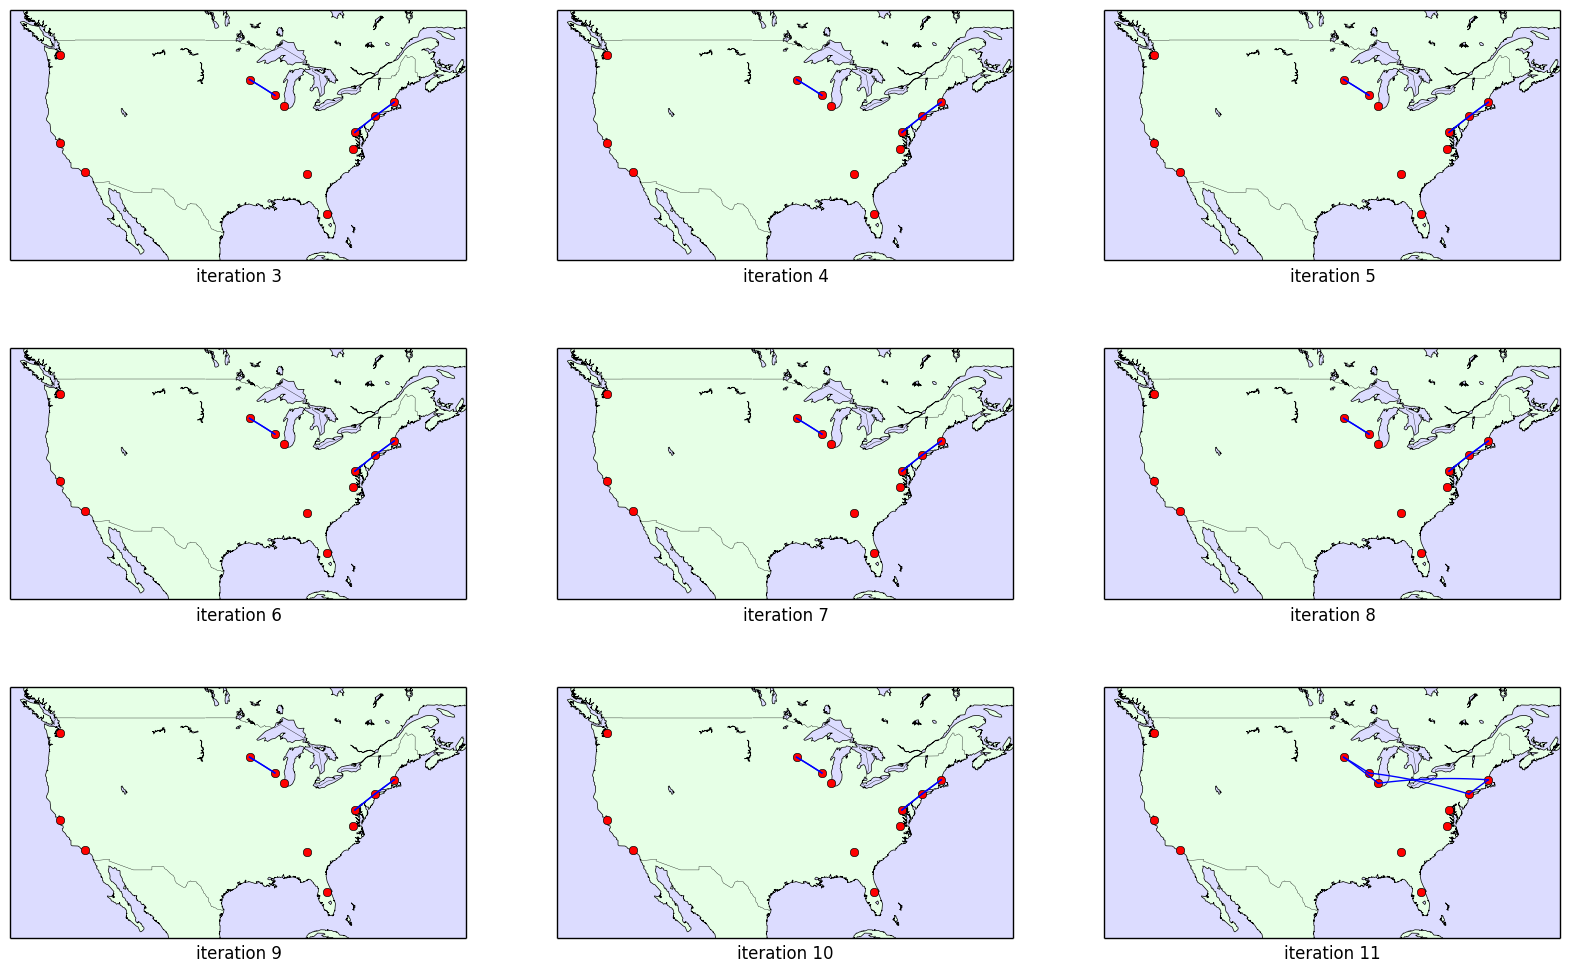

In [9]:
solveProblem(0)

### Test 2

Orlando is a great place to have fun (e.g. Disney, Universal Stuio). Based on Test1's setting, we set the Orlando's city_requirement be 1 and city_day_lowerlimit be 3 (i.e. We have to visit Orlando and stay at least 3 days). We run our functions, and then get the following results.

- Our travel plan is
    - Madison => Chicago (stay 1 day)
    - Chicago => Orlando (stay 3 day)
    - Orlando => New York (stay 2 days)
    - New York => Madison (travel end)
    
   
- The flights will take 3 days


- This travel plan seems reasonable

In [10]:
# Test setting [2] - want to stay in Oralando 3 days
city_requirement    = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
city_requirement[8] = 1
city_day_upperlimit = [3  3  3  3  3  3  3  3  3  3  3  3]
city_day_lowerlimit = [1  1  1  1  1  1  1  1  1  1  1  1]
city_day_lowerlimit[8] = 3
city_pre_score      = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
seed_city = 12
seed_city_day_upperlimit = 0
city_day_upperlimit[seed_city] = seed_city_day_upperlimit
max_money = 10000
max_day = 10;

solved
maximum comfort is :  738.8558948721268
[2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0]
56 New York  to  Madison
143 Chicago  to  Orlando
256 Orlando  to  New York
397 Madison  to  Chicago




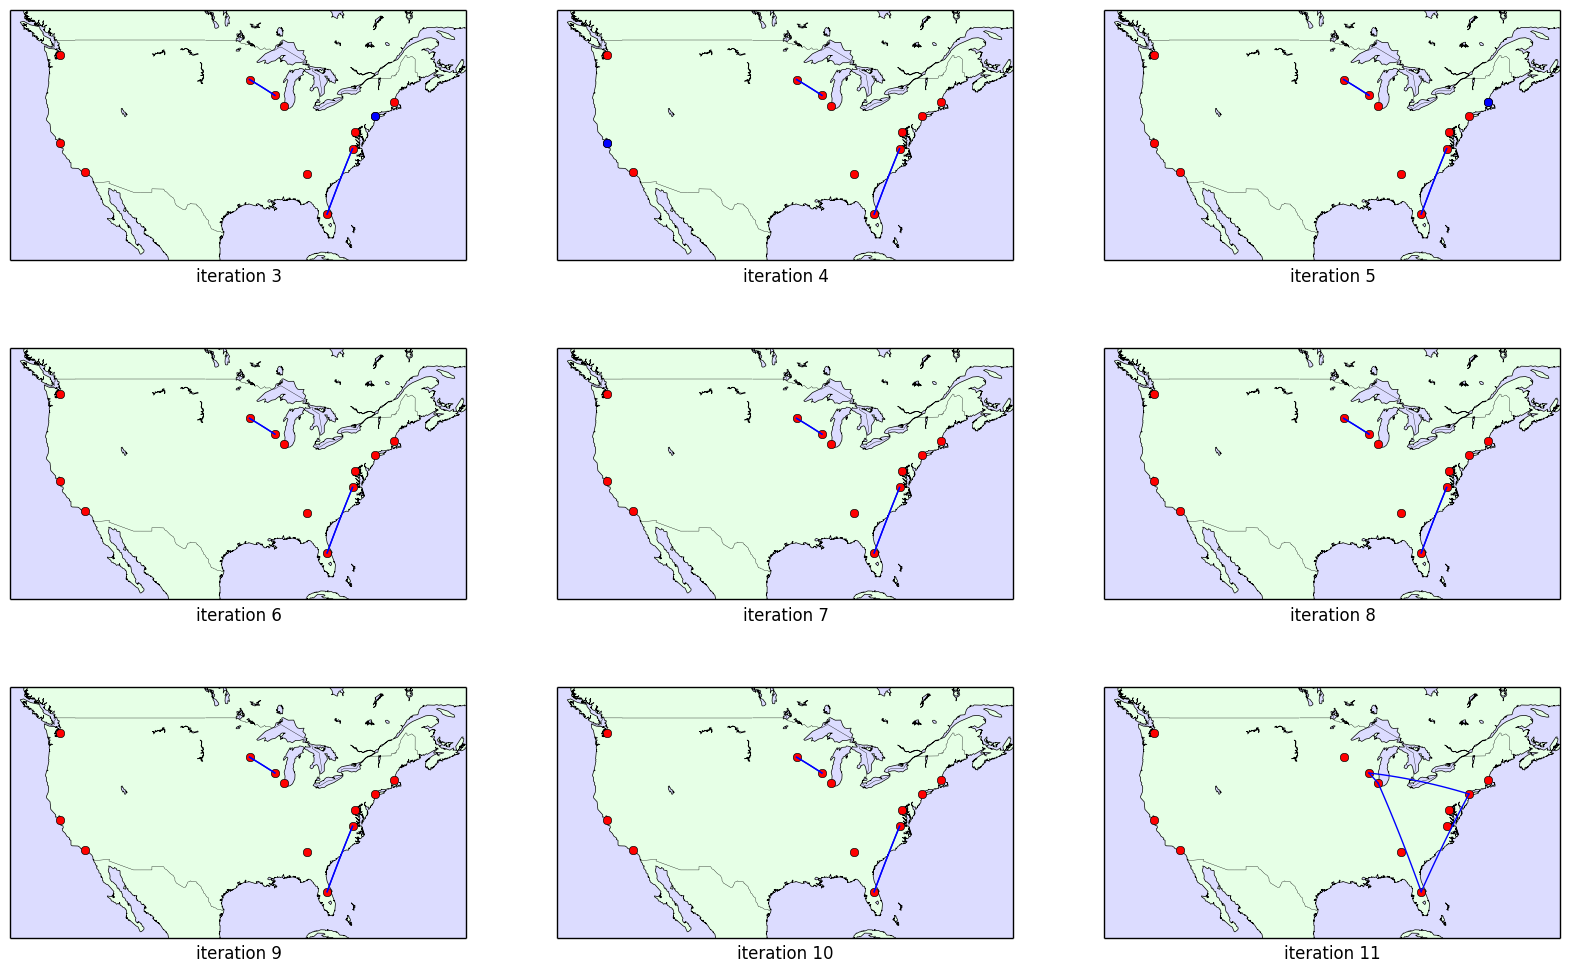

In [11]:
solveProblem(0)

### Test 3

Well, New York is a good place, but we have visited New York for many times. So we don't want to visit New York in this trip. Based on Test2's setting, we set the New York's city_requirement be 0 (i.e. We don't want to visit New York).. We run our functions, and then get the following results.

- Our travel plan is
    - Madison => Chicago (stay 2 day)
    - Chicago => Orlando (stay 3 day)
    - Orlando => Minneapolis (stay 1 days)
    - Minneapolis => Madison (travel end)
    
   
- The flights will take 3 days


- This travel plan seems reasonable

In [12]:
# Test setting [3] - want to stay in Oralando 3 days and don't want to go to New York
city_requirement    = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
city_requirement[8] = 1
city_requirement[1] = 0
city_day_upperlimit = [3  3  3  3  3  3  3  3  3  3  3  3]
city_day_lowerlimit = [1  1  1  1  1  1  1  1  1  1  1  1]
city_day_lowerlimit[8] = 3
city_pre_score      = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
seed_city = 12
seed_city_day_upperlimit = 0
city_day_upperlimit[seed_city] = seed_city_day_upperlimit
max_money = 10000
max_day = 10;

solved
maximum comfort is :  706.9907055759727
[0.0,0.0,0.0,2.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0]
143 Chicago  to  Orlando
187 Minneapolis  to  Madison
270 Orlando  to  Minneapolis
397 Madison  to  Chicago




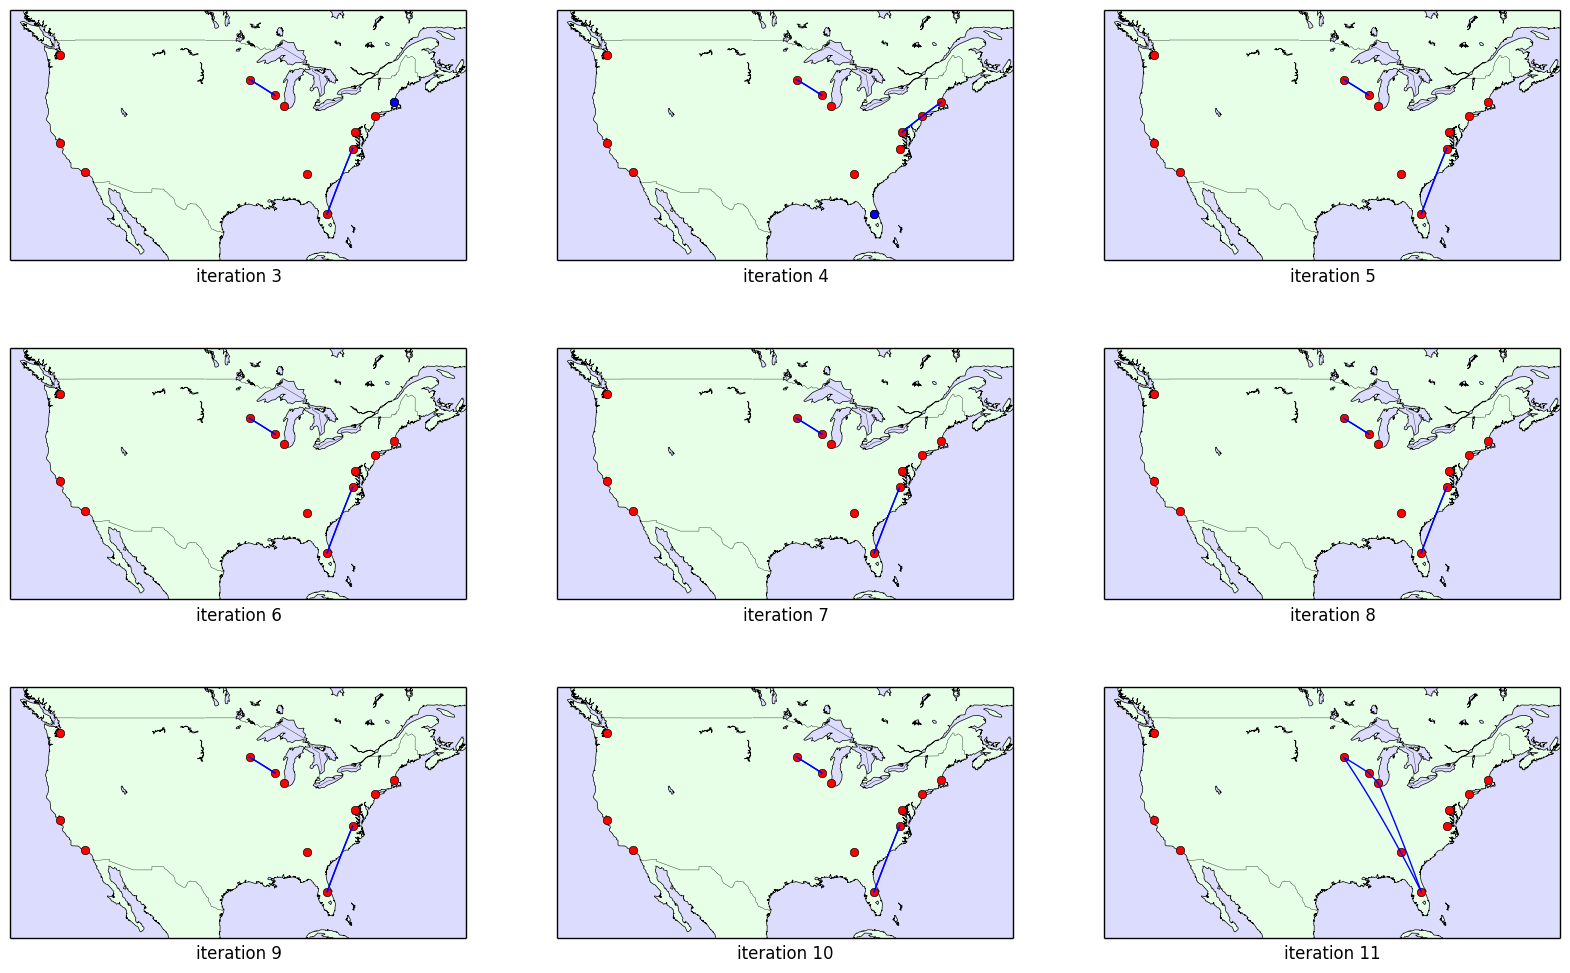

In [13]:
solveProblem(0)

### Test 4

This test is similar with Test1. The seed_city is still Madison, but our budget is limited (i.e. 400 dollars in total). Other settings are all default. We run our functions, and then get the following results.

- Our travel plan is
    - Madison => Minneapolis (stay 3 day)
    - Minneapolis => Chicago (stay 3 day)
    - Chicago => Madison (travel end)
    
   
- The flights will take 2 days


- This travel plan seems reasonable

In [14]:
# Test setting [4] - budget is very low
city_requirement    = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
city_day_upperlimit = [3  3  3  3  3  3  3  3  3  3  3  3]
city_day_lowerlimit = [1  1  1  1  1  1  1  1  1  1  1  1]
city_pre_score      = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
seed_city = 12
seed_city_day_upperlimit = 0
city_day_upperlimit[seed_city] = seed_city_day_upperlimit
max_money = 400
max_day = 10;

solved
maximum comfort is :  704.7304243282174
[0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
154 Chicago  to  Madison
168 Minneapolis  to  Chicago
400 Madison  to  Minneapolis




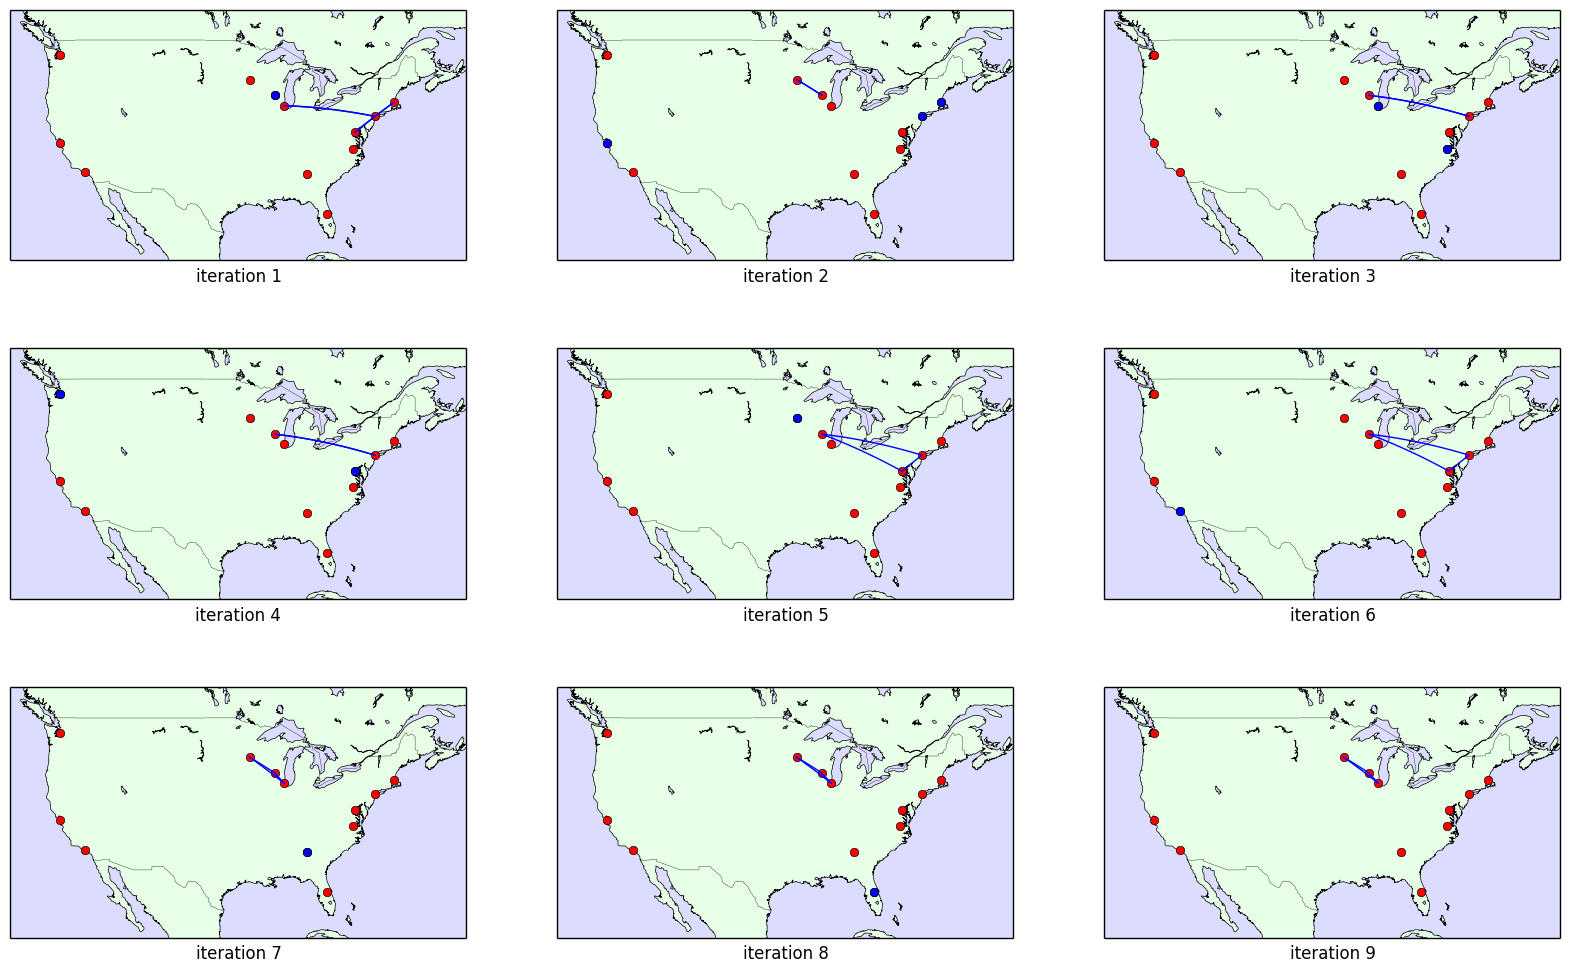

In [15]:
solveProblem(0)

### Test 5

In this test, our seed_city is Seattle (not Madison this time). And we think one day is too short for visiting a city, so the lower limit for each city is 3 days while New York is 6 days. We run our functions, and then get the following results.

- Our travel plan is
    - Seattle => San Francisco (stay 3 day)
    - San Francisco => New York (stay 4 day)
    - New York => Seattle (travel end)
    
   
- The flights will take 2 days


- This travel plan seems reasonable

In [16]:
# Test setting [5] - seed_city is Seattle
city_requirement    = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
city_day_upperlimit = [3  3  3  3  3  3  3  3  3  3  3  3]
city_day_upperlimit[1] = 6
city_day_lowerlimit = [3  3  3  3  3  3  3  3  3  3  3  3]
city_pre_score      = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
seed_city = 11
seed_city_day_upperlimit = 0
city_day_upperlimit[seed_city] = seed_city_day_upperlimit
max_money = 10000
max_day = 10;

solved
maximum comfort is :  875.5832799229256
[4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0]
54 New York  to  Seattle
322 San Francisco  to  New York
383 Seattle  to  San Francisco




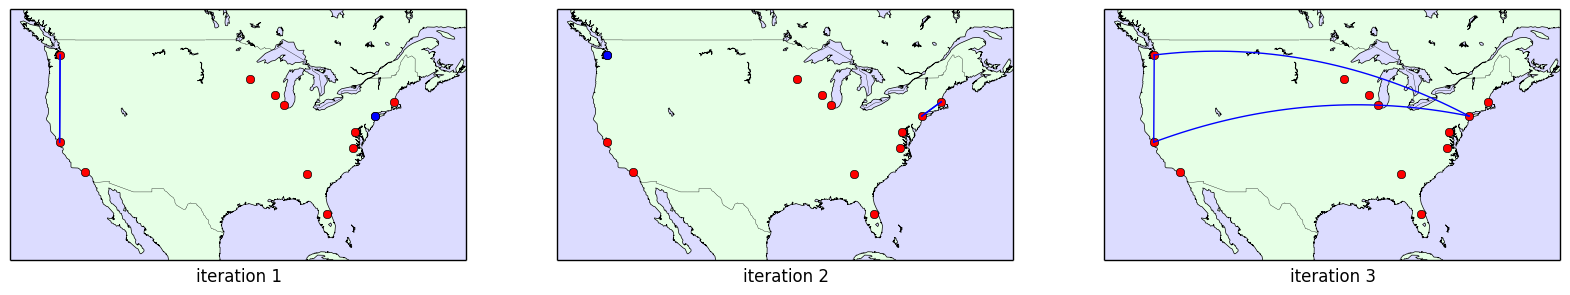

In [17]:
solveProblem(0)

### 4.B. Limitations###

The tests above show that our model works perfect on our assumptions. But some of our assumptions may not work in real life. The followings are some limitations of our model.

- Flying from one city to another city in U.S. always takes less than one day (maybe just several hours). We may still have hours go sightseeing when we arrive a new city.
- Price of a flight may be different in different days, even in adjacent days.
- Now the delight index of flights is calcaulated by our default function. But everyone has his/her own preference. Though we can set the delight index of cities by ourselves in our model, we may have no idea what exactly the number should be (e.g. 80 is big enough?). A personal recommendation may be a good idea.

## 5. Conclusion ##

In this project, we try to solve a problem in real life: how to make a travelling plan based with time, cost, and must-visit and must-not-visit constraints. We firstly build the mathematical model based on our assumption, and then implement it in Julia. Finally we test it in real data extrated from online, and the results show that our model works reasonably.

As for the future directions, we have the following ideas.
- Here we make an assumption that the flight price stays the same within several days. But in reality, instead, price of a flight can vary in different days. Actually we have come up with a model to do this: put the same edges for each day except the flight price and delight index, and make a constraint that only one edge can be selected within one day.
- Another assumption we make here is that each flight takes exactly one day. And in the next step, we can take the departure time and arrival time of each flight into consideration. For example, if a flight's departure time is 4am, it may have a very low delight index. If a flight's arrive time is 1pm, we may have half a day to go sightseeing.
- As we specify in section 3.B, we take walk score as delight index for each city, and simulate a delight index for each flight. While if we want this system suitable for each person, which means recommending travelling route based on personal habits, recommendation system can be introduced to make delight index more close and meaningful.